In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

C:\Users\kiano\AppData\Local\Temp\ipykernel_14552\97107199.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def Q_integ(y_prev, uu, dt, count):
    K = (.2)**(1/count**count)
    y_new = y_prev + K * (dt) * (uu) / 2
    return y_new

## Lower Limb Exoskeleton Robot 

In [3]:
class exo:
    def __init__(self, dt = 0.01):
        self.t = 0
        self.dt = dt
        self.q = np.zeros([3])
        self.qd = np.zeros([3])
        self.qdd = np.zeros([3])
        self.history = {'q':np.copy(self.q),'qd':np.copy(self.qd),'qdd':np.copy(self.qdd)}
        self.sensor = {'FSR': 0}
    def integrate_euler(self):
        # Euler integration
        self.q = self.q + self.qd * self.dt
        self.qd = self.qd + self.qdd * self.dt
        
    def dynamic(self, q, qd, qdd):
        # Constant values
        m_HK = 3.219
        m_KA = 3.326

        I_HK = 44.57
        I_KA = 51.34

        L_HK = .45
        L_KA = .45

        L_Hm = L_HK / 2
        L_Km = L_KA / 2

        g = 9.81

        # Extract angles and angular velocities
        Teta_H = q[0]
        Teta_K = q[1]

        Teta_H_d = qd[0]
        Teta_K_d = qd[1]

        # Function calls for EXO_M, EXO_C, and EXO_G need to be defined with the correct parameters in Python
        M = self.EXO_M(I_HK, I_KA, L_HK, L_Hm, L_Km, Teta_K, m_HK, m_KA)
        C = self.EXO_C(L_HK, L_Km, Teta_K, Teta_H_d, Teta_K_d, m_KA)
        G = self.EXO_G(L_HK, L_Hm, L_Km, Teta_H, Teta_K, g, m_HK, m_KA)

        # Jacobian matrix
        J = np.array([
            [45 * np.cos(Teta_H) - 45 * np.sin(Teta_H - Teta_K), -45 * np.sin(Teta_H - Teta_K),0],
            [45 * np.sin(Teta_H) + 45 * np.cos(Teta_H - Teta_K),  45 * np.cos(Teta_H - Teta_K),0],[0,0,0]
        ])
        return M, C, G, J
    def run(self, tau):
        M, C, G, J = self.dynamic(self.q, self.qd ,self.qdd)

        F_GR = 2*np.array([(1 - np.cos(.1 * self.t)), (1 + np.sin(.1 * self.t)),0])*0

        # Calculate acceleration 
        # tau needs to be defined, it is the control input
        
        self.history = {'q':np.copy(self.q),'qd':np.copy(self.qd),'qdd':np.copy(self.qdd)}

        f_ = np.linalg.pinv(M) @(- C @ self.qd - G - J.T @ F_GR)#C @ self.qd + G + J.T @ F_GR #
        g_ = np.linalg.pinv(M)#M #
        # self.qdd = g_@tau+f_

        self.qdd = np.linalg.pinv(M) @ (tau - C @ self.qd - G - J.T @ F_GR)
        self.t += self.dt
        count = int(self.t/self.dt)
        self.qd = Q_integ(self.qd, self.qdd + self.history['qdd'], self.dt, count)
        self.q = Q_integ(self.q, self.qd + self.history['qd'], self.dt, count)
        


        # tau = np.linalg.pinv(g_)@(r2d[i+1]-f_)
        # self.integrate_euler()
        return(f_, g_)



    def EXO_M(self, I_HK, I_KA, L_HK, L_Hm, L_Km, Teta_K, m_HK, m_KA):
        # Symbolic expressions
        t2 = np.sin(Teta_K)
        t3 = L_Km**2
        t4 = m_KA * t3
        t5 = L_HK * L_Km * m_KA * t2
        t6 = I_KA + t4 + t5

        # Mass matrix calculation
        M = np.zeros([3, 3])  
        M[0, 0] = I_HK + t5 + t6 + L_Hm**2 * m_HK + L_HK**2 * m_KA
        M[0, 1] = t6
        M[1, 0] = t6
        M[1, 1] = I_KA + t4

        return M 
    def EXO_C(self, L_HK, L_Km, Teta_K, Teta_H_d, Teta_K_d, m_KA):
        t2 = np.cos(Teta_K)
        C_val = L_HK * L_Km * m_KA * t2

        # Coriolis and centrifugal matrix calculation
        C = np.zeros([3, 3]) 
        C[0, 0] = C_val * Teta_K_d * 2.0
        C[0, 1] = -C_val * Teta_H_d * 2.0
        C[1, 0] = C_val * (Teta_H_d - Teta_K_d) * 2.0

        return C
    def EXO_G(self, L_HK, L_Hm, L_Km, Teta_H, Teta_K, g, m_HK, m_KA):
        t2 = np.sin(Teta_H)
        t4 = Teta_H - Teta_K
        t5 = np.cos(t4)

        # Gravity vector calculation
        G = np.array([
            g * (L_Hm * m_HK * t2 + L_HK * m_KA * t2 + L_Km * m_KA * t5),
            L_Km * g * m_KA * t5,
            0.0
        ])
        
        return G
    def reset(self):
        pass

### Make Reference Data

In [4]:
import scipy.io as sc
temp1 = sc.loadmat('Data1.mat')
r = temp1['data']['Y'][0][0]
r = np.concatenate((r, np.zeros([r.shape[0],1])),1)
dt = 0.01
# r = r[0:3000]
r = r[260000:263000]
r = r/180*np.pi
# r = (r-r.min())/(r.max()-r.min())
rd = np.zeros(r.shape)
r2d = np.zeros(r.shape)
for i in tqdm(range(r.shape[0]-1)):
    rd[i+1] = (r[i+1] - r[i])/dt
    r2d[i+1] = (rd[i+1] - rd[i])/dt

100%|██████████| 2999/2999 [00:00<00:00, 145304.47it/s]


# Impedance Controller

In [5]:
class ImpedanceController:
    def __init__(self, K, D, desired_trajectory, desired_forces, dt):
        self.K = K  # Stiffness matrix
        self.D = D  # Damping matrix
        self.x_des_traj = desired_trajectory['x']
        self.xd_des_traj = desired_trajectory['xd']
        self.xdd_des_traj = desired_trajectory['xdd']
        self.F_des_traj = desired_forces
        self.dt = dt
        self.time = 0
        self.index = 0

    def update_desired(self):
        self.index = int(np.round(self.time / self.dt))
        self.x_des = self.x_des_traj[self.index]
        self.xd_des = self.xd_des_traj[self.index]
        self.xdd_des = self.xdd_des_traj[self.index]
        self.F_des = self.F_des_traj[self.index]

    def control(self, x, xd):
        self.update_desired()
        force = (self.K.dot(self.x_des - x) + self.D.dot(self.xd_des-xd) + self.F_des)
        self.time += self.dt
        return force

In [6]:
window = 20

In [7]:
K = np.diag([390, 374, 0])
D = np.diag([305, 300, 0])*50/5

dt = 0.01  # Define your timestep

# Create an instance of your exo class
exoskeleton = exo(dt)

dk = dt

# robot = exo(dt)
exoskeleton.q = r[0]
q2 = [exoskeleton.q]
# tau_hist2 = [[0,0,0]]*99
tau_hist2_IC = [[0,0,0]]
# tau_hist3 = [[0,0,0]]
impedance_controller = ImpedanceController(K, D, desired_trajectory={'x':r,'xd':rd,'xdd':r2d}, desired_forces=r*0, dt=dt)
for i in tqdm(range(r.shape[0]-1)):
    impedance_controller.update_desired()
    tau = impedance_controller.control(exoskeleton.q, exoskeleton.qd)
    tau_hist2_IC.append(tau.tolist())
    if i>=window:
        tau = np.array([pd.Series(np.array(tau_hist2_IC)[-window:,0]).rolling(window).mean().values[-1],pd.Series(np.array(tau_hist2_IC)[-window:,1]).rolling(window).mean().values[-1],0])
        tau_hist2_IC[-1] = tau
        # tau = np.clip(tau,-1000,1000)
    exoskeleton.run(tau)
    q2.append(exoskeleton.q)
    # tau_hist3.append(tau.tolist())

    error = np.max((r[i+1]-exoskeleton.q)**2)

    # q2.append(exoskeleton.q)
    # tau_hist2.append(tau.tolist())
q2 = np.array(q2)
tau_hist2_IC = np.array(tau_hist2_IC)
# tau_hist3 = np.array(tau_hist3)


100%|██████████| 2999/2999 [00:05<00:00, 576.53it/s]


In [10]:
k = np.linspace(0,20, r.shape[0])#np.arange(0, Full_time + dk, dk)


In [11]:
import pandas as pd
# returns = tau_hist[:,0]
def rolllli(returns, window = 100):
    rolling_mean = pd.Series(returns).rolling(window).mean()
    return(rolling_mean)
    # std = pd.Series(returns).rolling(window).std()
# plt.plot(rolling_mean)
# plt.fill_between(range(len(returns)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.4)

findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not found.
findfont: Font family 'Cambria Math' not

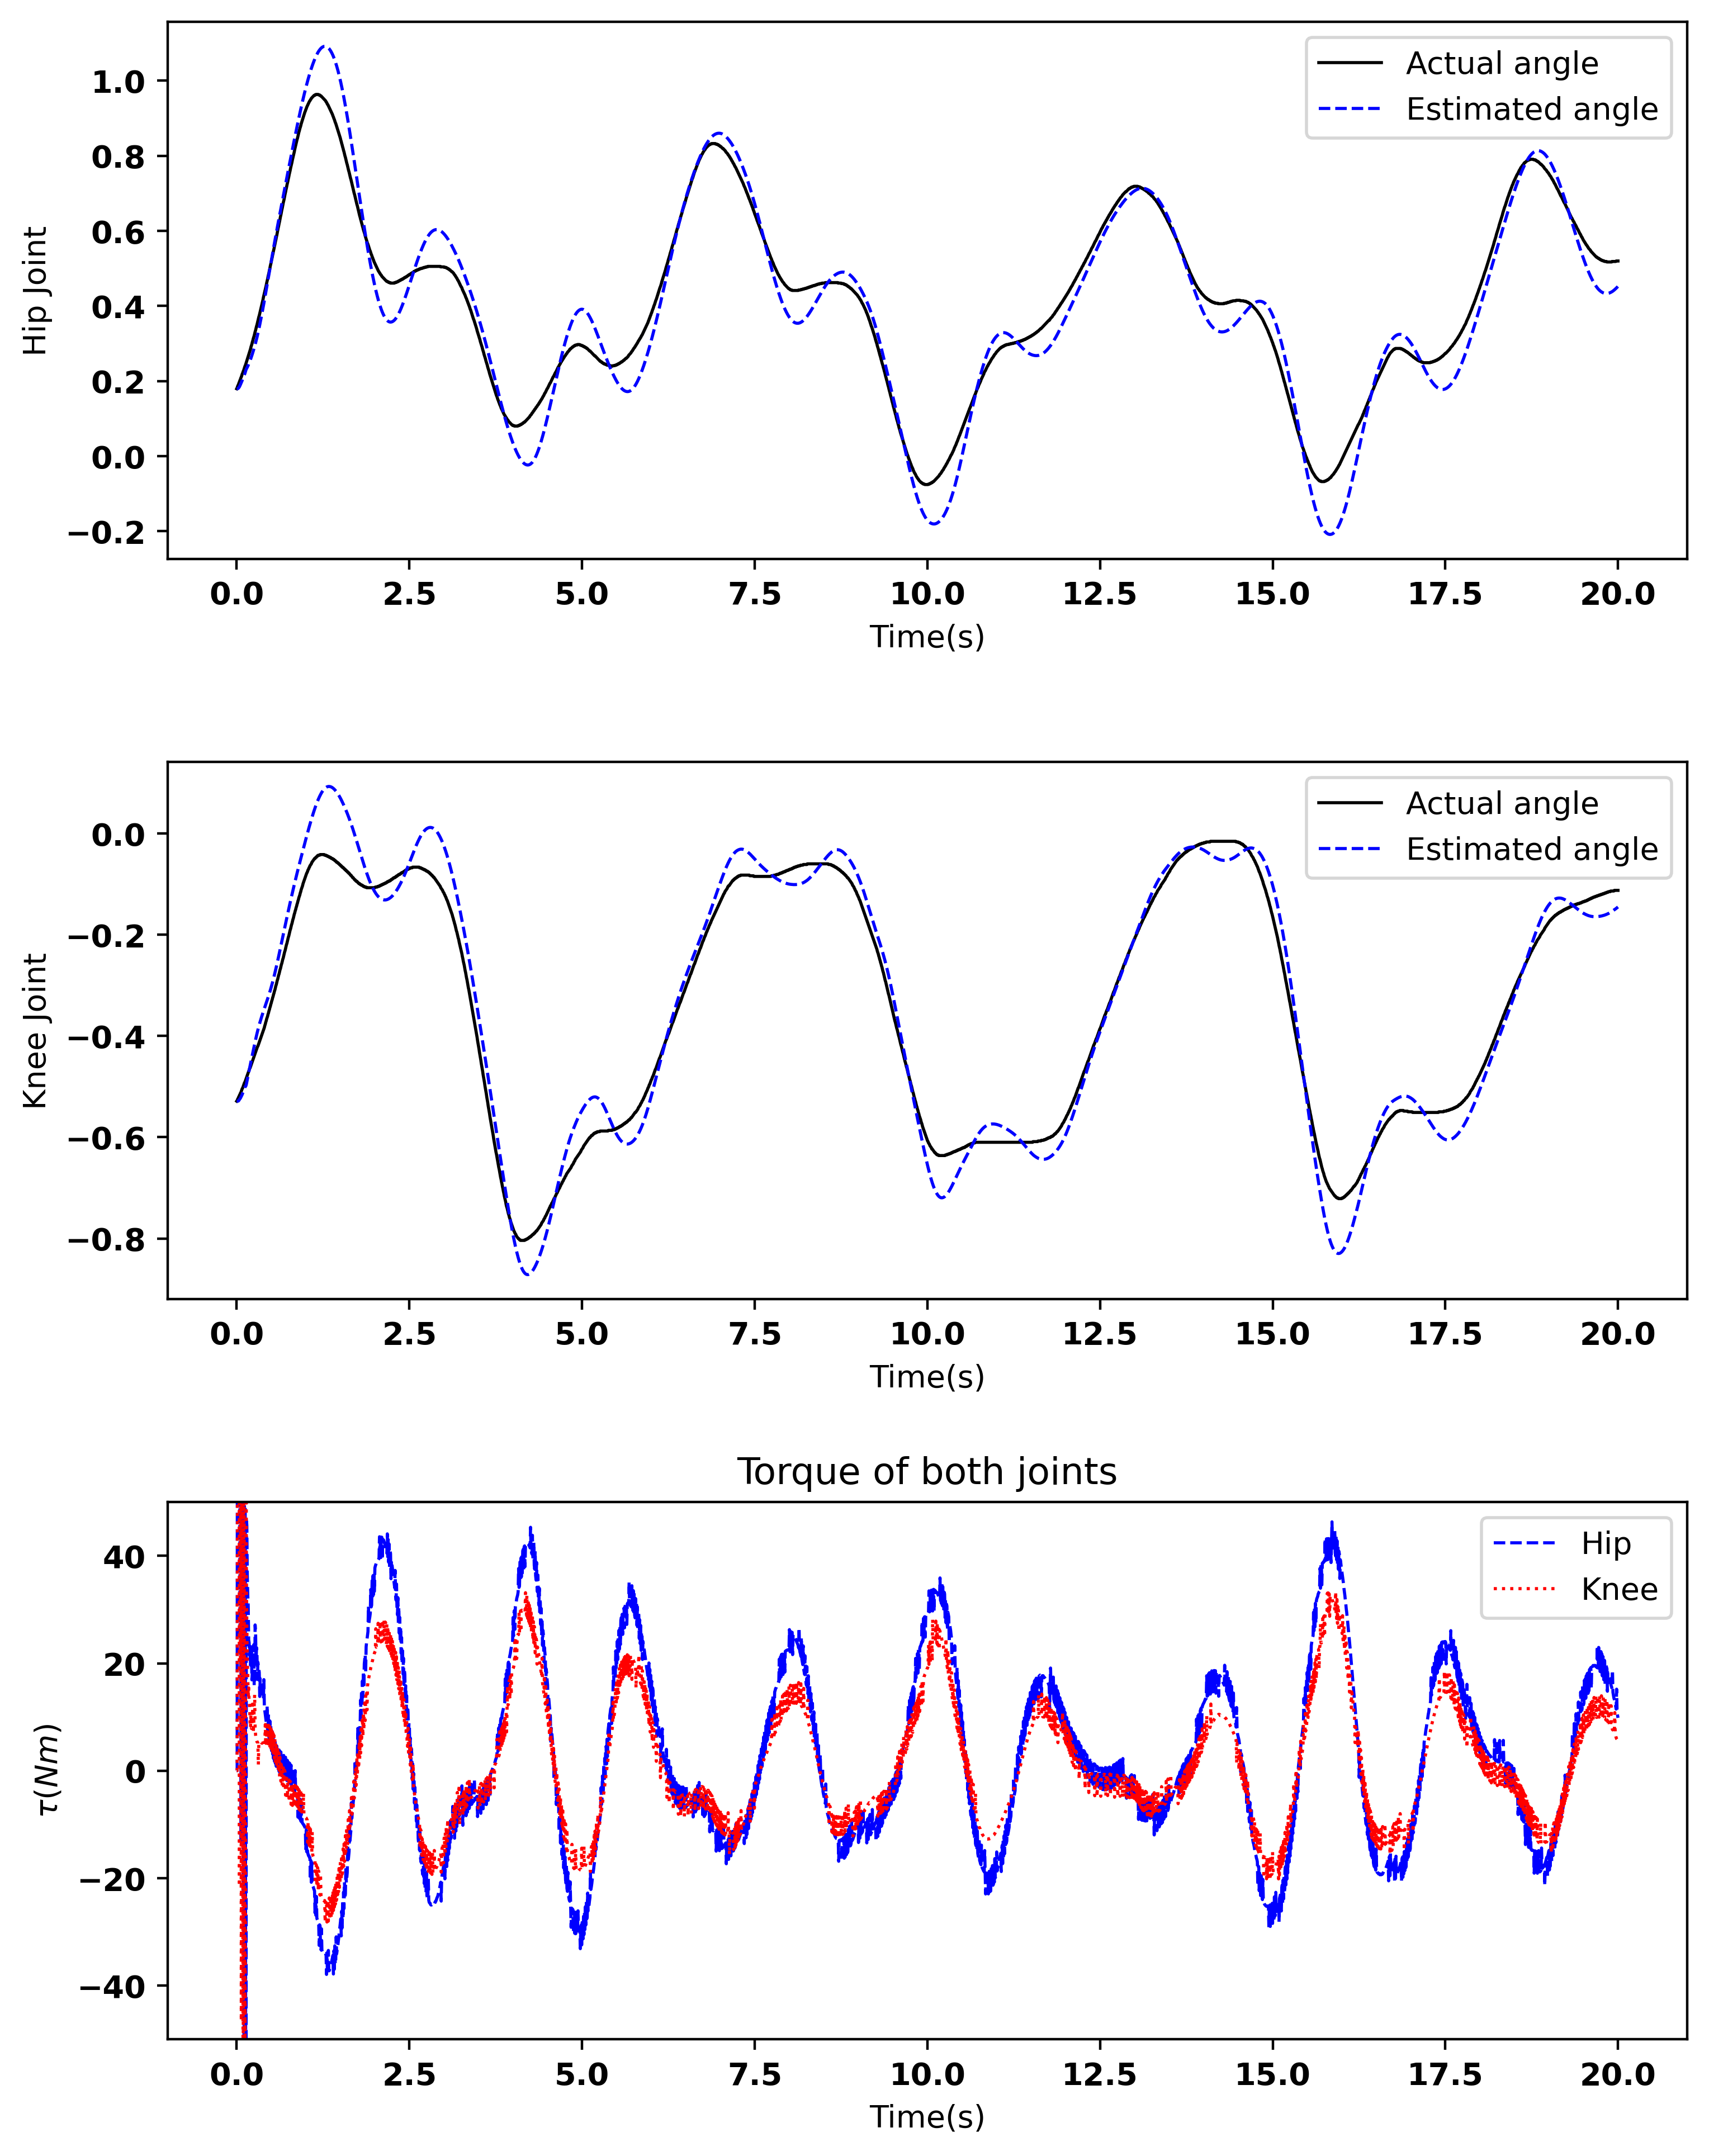

In [12]:
plt.figure(4,figsize=(8, 10), dpi=400)
plt.subplot(3, 1, 1)
plt.plot(k, r[:,0], label='Actual angle', linestyle='-', color='black', linewidth=1)
plt.plot(k, q2[:,0], label='Estimated angle', linestyle='--', color='blue', linewidth=1)
plt.xlabel('Time(s)')
plt.ylabel('Hip Joint')
plt.xticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.yticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(k, r[:,1], label='Actual angle', linestyle='-', color='black', linewidth=1)
plt.plot(k, q2[:,1], label='Estimated angle', linestyle='--', color='blue', linewidth=1)
plt.xlabel('Time(s)')
plt.ylabel('Knee Joint')
plt.xticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.yticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(k, tau_hist2_IC[:,0]/5, label='Hip', linestyle='--', color='blue', linewidth=1)#rolllli(tau_hist2[:,0]/5)
plt.plot(k, tau_hist2_IC[:,1]/5, label='Knee', linestyle=':', color='red', linewidth=1)#rolllli(tau_hist2[:,1]/5)
# plt.plot(k, tau_hist[:,2]/50, label='Ankle', linestyle='-.', color=[1, 0.6, 0.7843137383461], linewidth=1)
plt.title('Torque of both joints')
plt.xlabel('Time(s)')
plt.ylabel(r'$\tau(Nm)$')
plt.ylim([-50, 50])
plt.xticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.yticks(fontname='Cambria Math', fontsize=10, fontweight='bold')
plt.legend()


plt.tight_layout(pad=2.0)
# plt.savefig('Impedance_Control_good.png',dpi=400)